In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping


SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.10.0


In [2]:
# Loading dataset
dataset = np.load('char_dataset.npz')
X = dataset['x']
Y = dataset['y']
print(X.shape)
print(Y.shape)

(230, 14, 1280)
(230,)


In [3]:
# Sampling data into 250ms duration
def sampling250ms(X, Y):
    X_new = np.zeros((36110,32,14))
    Y_new = np.zeros((36110,))
    npt = 32
    stride = 8
    ctr = 0
    for i in range(0, X.shape[0]):
        y = Y[i]
        a= X[i,:,:]
        a = a.transpose()
        val = 0
        while val<=(len(a)-npt):
            x = a[val:val+npt,:]
            X_new[ctr,:,:] = x
            Y_new[ctr] = y
            val = val+stride
            ctr = ctr+1
    return X_new, Y_new

In [4]:
X_new, Y_new = sampling250ms(X, Y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=SEED)

print(f'''
X_train shape:{X_train.shape} -> Train Labels: {y_train.shape[0]}
X_test shape:{X_test.shape} -> Test Labels: {y_test.shape[0]}''')


X_train shape:(28888, 32, 14) -> Train Labels: 28888
X_test shape:(7222, 32, 14) -> Test Labels: 7222


In [6]:
# Creating the original model

def create_model(optimizer='adam',
                 initializer1 = tf.keras.initializers.HeNormal(seed=SEED),
                 initializer2 = tf.keras.initializers.HeNormal(seed=SEED), 
                 dropout=0.5):
    model = Sequential()
    model.add(Input(shape=(32,14)))
    model.add(BatchNormalization())
    model.add(Conv1D(128, kernel_size=10, strides=1, activation='relu', padding='same', kernel_initializer = initializer1))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(dropout))
    model.add(LSTM(256, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_initializer=initializer2))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 14)           56        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           18048     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 128)          512       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                        

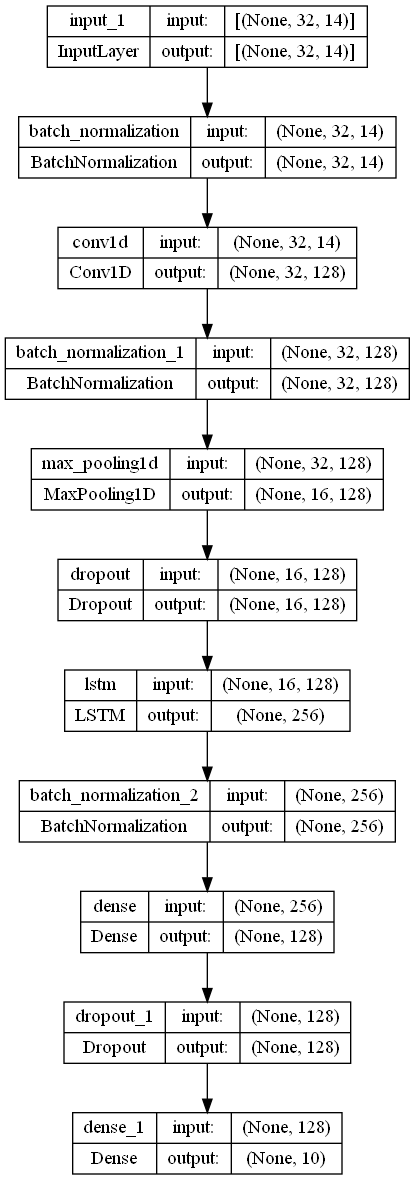

In [7]:
# Visualizing Model
plot_model(model, to_file = 'Original_model.png', show_shapes=True)

In [8]:
# Training Model with EarlyStopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)
history = model.fit(X_train, y= to_categorical(y_train), validation_split=0.2, epochs=500, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/500
181/181 [==============================] - 6s 15ms/step - loss: 2.5159 - accuracy: 0.1356 - val_loss: 2.3384 - val_accuracy: 0.0983
Epoch 2/500
181/181 [==============================] - 2s 10ms/step - loss: 2.2544 - accuracy: 0.1604 - val_loss: 2.4991 - val_accuracy: 0.1087
Epoch 3/500
181/181 [==============================] - 2s 10ms/step - loss: 2.1853 - accuracy: 0.1860 - val_loss: 2.2417 - val_accuracy: 0.1364
Epoch 4/500
181/181 [==============================] - 2s 9ms/step - loss: 2.1309 - accuracy: 0.2145 - val_loss: 2.1266 - val_accuracy: 0.2210
Epoch 5/500
181/181 [==============================] - 2s 10ms/step - loss: 2.0617 - accuracy: 0.2469 - val_loss: 2.0030 - val_accuracy: 0.2625
Epoch 6/500
181/181 [==============================] - 2s 10ms/step - loss: 1.9994 - accuracy: 0.2698 - val_loss: 1.9182 - val_accuracy: 0.3020
Epoch 7/500
181/181 [==============================] - 2s 10ms/step - loss: 1.9418 - accuracy: 0.2941 - val_loss: 1.8543 - val_accuracy: 

226/226 [==============================] - 1s 2ms/step

The average accuracy of the exploring model on Test Data is: 0.8771808363334257


<AxesSubplot:>

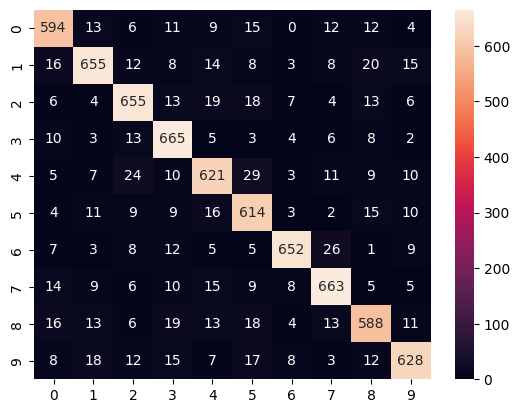

In [9]:
# Test on never-seen data
pred = model.predict(X_test)
y_pred = np.argmax(pred,axis=1)

print(f'\nThe average accuracy of the exploring model on Test Data is: {accuracy_score(y_pred,y_test)}')
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True ,fmt='g')